In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# S/b Text(0, 0.5, 'Inches')

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 


#
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date one year from the last date in data set.
last_year_date = pd.to_datetime(most_recent_date) + pd.DateOffset(years= -1)
last_year_date = last_year_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
frame_df = pd.DataFrame(rows)
frame_df.columns = ["Date", "precipitation"]

# Sort the dataframe by date
frame_df = frame_df.sort_values(['Date'],ascending=True)

#drop nulls
frame_df = frame_df.dropna()
frame_df["Date"] = pd.to_datetime(frame_df["Date"])
frame_df.set_index("Date", inplace=True)

frame_df


,precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [30]:
plot_df = pd.DataFrame(frame_df.groupby(["Date"])["precipitation"].sum())
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='Date', ylabel='Inches'>

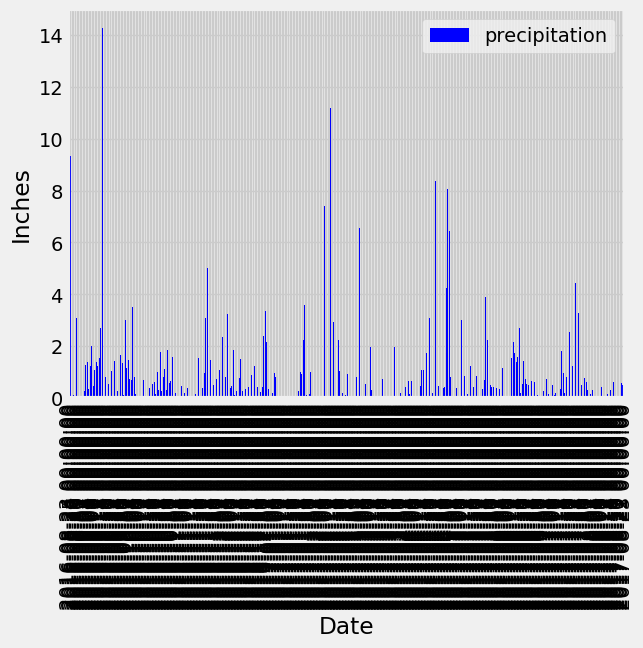

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data

plot_df.plot(kind="bar", color = "b",
              ylabel = "Inches")



In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
frame_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
#[(9,)]

session.query(func.count(Station.station)).all()


[(9,)]

In [34]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(sqlalchemy.desc(func.count())).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(sqlalchemy.desc(func.count())).first().station
most_active_station_id

'USC00519281'

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# [(54.0, 85.0, 71.66378066378067)]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

[(54.0, 85.0, 71.66378066378067)]

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_station_date = session.query(Measurement.station, Measurement.date).\
    filter(Measurement.station == most_active_station_id).\
    order_by(sqlalchemy.desc(Measurement.date)).first().date
last_station_date

last_year_date = pd.to_datetime(last_station_date) + pd.DateOffset(years= -1)
last_year_date = last_year_date.strftime("%Y-%m-%d")
last_year_date

'2016-08-18'

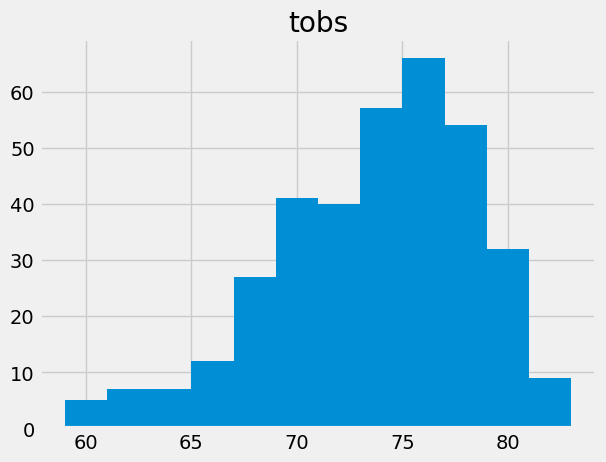

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
records = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= last_year_date).all()
station_df = pd.DataFrame(records)
station_df.hist(bins=12)
plt.xlabel = "Temperature"
plt.show()

# Close Session

In [41]:
# Close Session
session.close()